## Body Language Analysis

In [128]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

In [129]:
# Read the data
experiment_file_path = '../data/experiment-new.csv'
df_experiment = pd.read_csv(experiment_file_path)

In [130]:
# Clean the data # Clean the scores
df_experiment.columns = [c.replace(' ', '_') for c in df_experiment.columns]
df_experiment.Score = df_experiment.Score.map(lambda x: int(x[0]))
df_experiment.Score3 = df_experiment.Score3.map(lambda x: int(x[0]))

# Rename some columns for convenience
df_experiment['Country'] = df_experiment['1.1_Which_country_are_you_from?']
df_experiment['Gender'] = df_experiment['1.2_Please_choose_your_gender']
df_experiment.drop(columns=['1.1_Which_country_are_you_from?', '1.2_Please_choose_your_gender'], inplace=True)

# Filter out the rows required
retain_cols = ['Country', 'Gender', 'Age', 'Calc', 'Calc2', 'Calc3', 'Calc4', 'Calc5', 'Calc6', 'Calc7', 'Calc8', 'Score', 'Calc9', 'Calc10', 'Calc11', 'Calc12', 'Calc13', 'Calc14', 'Score3']
df_experiment = df_experiment.filter(items=retain_cols, axis='columns')

In [131]:
df_experiment.columns

Index(['Country', 'Gender', 'Age', 'Calc', 'Calc2', 'Calc3', 'Calc4', 'Calc5',
       'Calc6', 'Calc7', 'Calc8', 'Score', 'Calc9', 'Calc10', 'Calc11',
       'Calc12', 'Calc13', 'Calc14', 'Score3'],
      dtype='object')

In [132]:
display(df_experiment.sample(5))

,Country,Gender,Age,Calc,Calc2,Calc3,Calc4,Calc5,Calc6,Calc7,Calc8,Score,Calc9,Calc10,Calc11,Calc12,Calc13,Calc14,Score3
51,China,Female,26,0,-1,0,1,1,1,1,1,4,1,1,2,0,-1,1,6
44,Greece,Male,30,2,-2,0,1,-1,1,2,0,3,-1,-2,1,1,-1,1,2
34,Germany,Female,25,1,0,0,0,0,0,1,0,2,1,0,0,-1,-1,0,4
46,India,Female,28,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,2
25,India,Female,26,-1,-1,0,-1,-1,-1,-2,-2,3,-2,-1,-2,-1,-1,-1,3


In [133]:
# Group single respondents from a particular country into a group called 'Other'
num, country = df_experiment.Country.value_counts(), df_experiment.Country.value_counts().index
countries_with_single_respondent = []
for c, n in zip(country, num):
    if(n == 1):
        countries_with_single_respondent.append(c)
df_experiment.Country.replace(to_replace=countries_with_single_respondent, value='Other', inplace=True)
num, country = df_experiment.Country.value_counts(), df_experiment.Country.value_counts().index # update values
country_total = dict((c, n) for c, n in zip(country, num))
country_total

{'India': 20,
 'Other': 15,
 'Germany': 11,
 'Greece': 4,
 'Tunesia': 3,
 'China': 2,
 'Ecuador': 2,
 'Denemark': 2,
 'Iran': 2}

In [90]:
# How many countries answered the survey

countries = df_experiment['Country']
print("Total number of participants: ", countries.count())
print("\nDifferent nationalities in survey:\n", countries.value_counts())
# display(countries.value_counts())
# countries.nunique()

Total number of participants:  61

Different nationalities in survey:
 India       20
Other       15
Germany     11
Greece       4
Tunesia      3
China        2
Ecuador      2
Denemark     2
Iran         2
Name: Country, dtype: int64


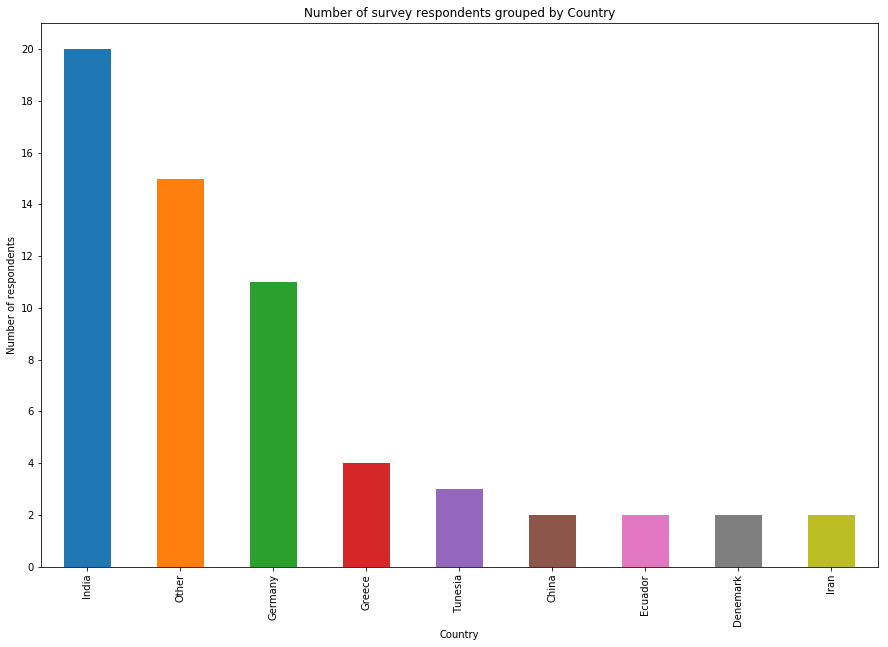

In [91]:
# Number of respondents, grouped by country
fig = plt.figure()
props = {
    'title' : 'Number of survey respondents grouped by Country',
    'yticks' : range(0,22,2),
    'figsize' : (15, 10),
#     "ax" : {
#         'get_figure' : fig,
#         'set_xlabel' : 'abc',
#         'set_ylabel' : 'cba'
#     },
}
ax = df_experiment['Country'].value_counts().plot.bar(**props)
ax.set_xlabel('Country')
ax.set_ylabel('Number of respondents')
ax = fig.add_subplot(ax)
fig.savefig('respondents-per-country.eps', dpi=5000)

In [92]:
# score above 3 sorted by country

country_based_score = df_experiment[['Country', 'Score', 'Score3']]
country_based_score_greaterthan3 = country_based_score.loc[(country_based_score['Score'] > 3) | (country_based_score['Score3'] > 3)]
countries_count_score = country_based_score_greaterthan3['Country']
# countries_count_score.value_counts()

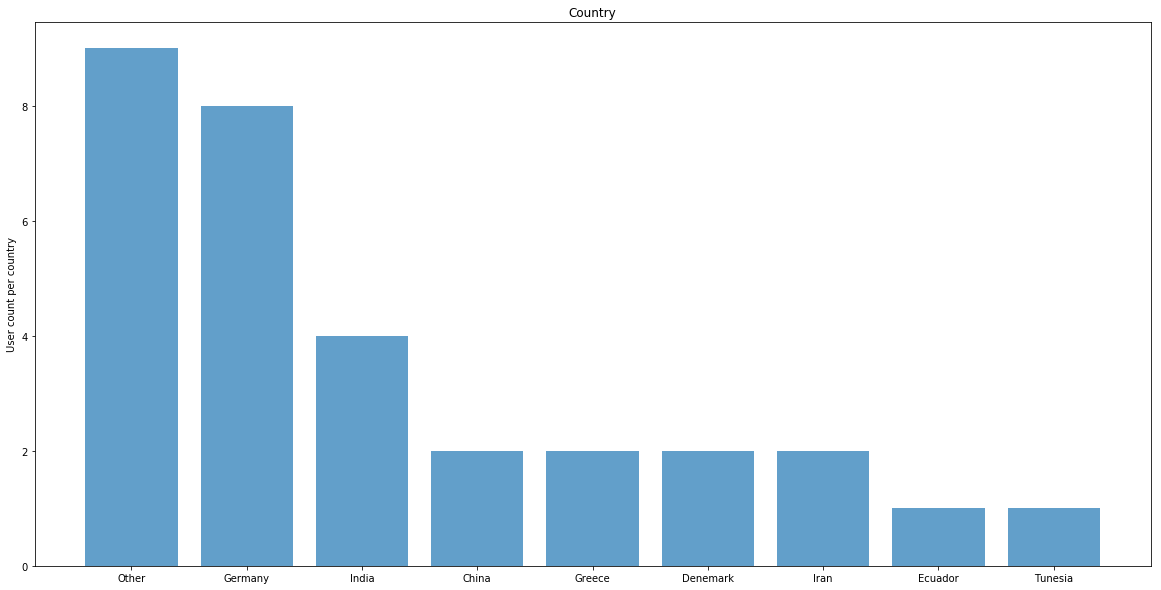

In [93]:
objects = countries_count_score.value_counts().index
y_pos = np.arange(len(objects))
performance = countries_count_score.value_counts()

fig = plt.figure(figsize=(20,10))
plt.bar(y_pos, performance, align='center', alpha=0.7)
plt.xticks(y_pos, objects)
# plt.xticklabels(rotation=30)
plt.ylabel('User count per country')
plt.title('Country')
fig.savefig('increase-of-awareness-byCountry.png')
fig.show()

# {'title': 'Number of people with high score, grouped by Country',
#  'xlabel': 'Country',
#  'ylabel': 'Number of people'}

In [94]:
# Score above 3 sorted by gender

gender_based_score = df_experiment[['Gender', 'Score', 'Score3']]
total_males = gender_based_score.loc[gender_based_score['Gender'] == "Male"]
total_males = total_males.count()
total_females = gender_based_score.loc[gender_based_score['Gender'] == "Female"]
total_females = total_females.count()

gender_based_score_greaterthan3 = gender_based_score.loc[(gender_based_score['Score'] > 3) | (gender_based_score['Score3'] > 3)]
gender_count_score = gender_based_score_greaterthan3['Gender']
print("Total number of people sorted by Gender: \n Males %d Females %d" %(total_males[1], total_females[1]) )
print("Score above 3 sorted by Gender:\n", gender_count_score.value_counts())

calculate_percentage_males = (26/total_males[1]) * 100
calculate_percentage_females = (5/total_females[1]) * 100
print("Percentage Males: %d%% Females: %d%%" %(calculate_percentage_males, calculate_percentage_females))

Total number of people sorted by Gender: 
 Males 50 Females 11
Score above 3 sorted by Gender:
 Male      26
Female     5
Name: Gender, dtype: int64
Percentage Males: 52% Females: 45%


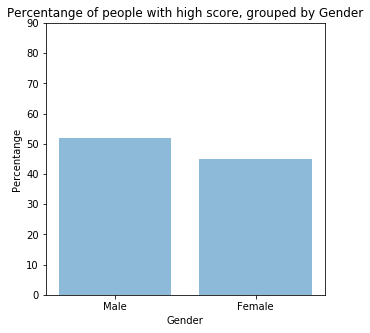

In [95]:
objects = ('Male', 'Female')
y_pos = np.arange(len(objects))
performance = [52, 45]
 
plt.figure(figsize=(5,5))
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Percentange')
plt.yticks(range(0,100,10))
plt.xlabel('Gender')
plt.title('Percentange of people with high score, grouped by Gender')
plt.savefig('highest-grade-gender.eps', dpi=5000)
plt.show()

In [156]:
# Functions to calculate the the user's awareness before and after the survey
# Each respondent is assigned a value True/False based on their answers, before and after the survey
def taboo_rating(row):
    count = 0
    if(row['Calc'] > 0):
        count+=1
    if(row['Calc2'] > 0):
        count+=1
    if(row['Calc3'] > 0):
        count+=1
    if(row['Calc4'] > 0):
        count+=1
    if(row['Calc5'] > 0):
        count+=1
    if(row['Calc6'] > 0):
        count+=1
    if(row['Calc7'] > 0):
        count+=1
    if(row['Calc8'] > 0):
        count+=1
    if(count >= 2):
        return True
    else: 
        return False
    
def body_lang_rating(row):
    count = 0
    if(row['Calc9'] > 0):
        count+=1
    if(row['Calc10'] > 0):
        count+=1
    if(row['Calc11'] > 0):
        count+=1
    if(row['Calc12'] > 0):
        count+=1
    if(row['Calc13'] > 0):
        count+=1
    if(row['Calc14'] > 0):
        count+=1
    if(count >= 2):
        return True
    else: 
        return False

def calculate_percentage_country(subject_dataframe, country_total):
    subject_dict = {}
    aware_countries, num = subject_dataframe.Country.value_counts().index, subject_dataframe.Country.value_counts()
    for c, n in zip(aware_countries, num):
        print(c, n)
        print(round((n/country_total.get(c))*100))
        subject_dict.append(c, round((n/country_total.get(c))*100))
    return subject_dict
    

In [157]:
# Applying the above functions and separating relavant data into df_taboo and df_bodylang
df_experiment['taboo_rating'] = df_experiment.apply(taboo_rating, axis=1)
df_experiment['body_lang_rating'] = df_experiment.apply(body_lang_rating, axis=1)

# Filter based on taboo rating and Score
df_taboo = df_experiment[['Country', 'Gender', 'Age', 'taboo_rating', 'Score']]
df_taboo = df_taboo.loc[(df_taboo['taboo_rating'] == True) & (df_taboo['Score'] > 3)]

# Filter based on bodylang rating and Score
df_bodylang = df_experiment[['Country', 'Gender', 'Age', 'body_lang_rating', 'Score3']]
df_bodylang = df_bodylang.loc[(df_bodylang['body_lang_rating'] & (df_bodylang['Score3'] > 3))]

# Represent the above data Graphically including Indian-subcontinent
fig = plt.figure()
# props_ax1 = {
#     'title' : 'Awareness of Taboo grouped by Country',
#     'set_xlabel' : 'Country',
#     'ylabel' : 'Score',
#     'xticks' : df_taboo.Country.tolist(),
# #     'figsize' : (10, 5)
# }
# df_taboo.plot(x='Country', y='Score', kind='bar')
calculate_percentage_country(df_bodylang, country_total=country_total)
# zip(country, num)
# .plot(kind='bar')
# ax1 = fig.add_subplot(2,2,1)
# ax1.set(**props_ax1)
# taboo_aware

Other 3
20


AttributeError: 'dict' object has no attribute 'append'

<Figure size 432x288 with 0 Axes>

In [98]:
# BF, Score(BY)
# check how BF and Score relate to each other

In [99]:
# separate India from dataframe
# compare calc values for them

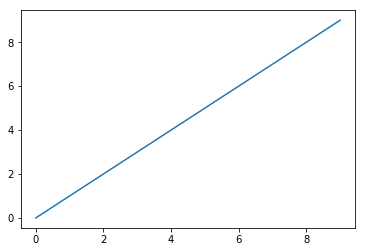

In [100]:
plt.plot(np.arange(10))

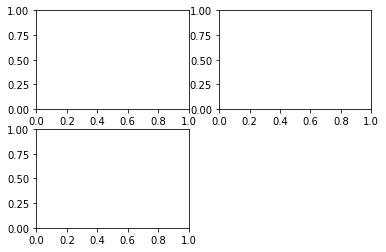

In [101]:
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)

(array([ 2.,  3.,  1.,  7.,  4.,  6.,  7., 10.,  9.,  7.,  7.,  7.,  6.,
         5.,  6.,  7.,  2.,  1.,  0.,  3.]),
 array([-2.00012126, -1.79571163, -1.59130199, -1.38689236, -1.18248273,
        -0.97807309, -0.77366346, -0.56925382, -0.36484419, -0.16043456,
         0.04397508,  0.24838471,  0.45279435,  0.65720398,  0.86161361,
         1.06602325,  1.27043288,  1.47484252,  1.67925215,  1.88366178,
         2.08807142]),
 <a list of 20 Patch objects>)

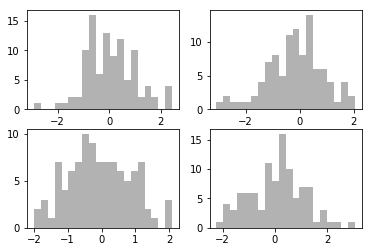

In [102]:
fig, axes = plt.subplots(2,2)
axes[0,1].hist(np.random.randn(100), bins=20, color='k', alpha=0.3)
axes[1,1].hist(np.random.randn(100), bins=20, color='k', alpha=0.3)
axes[0,0].hist(np.random.randn(100), bins=20, color='k', alpha=0.3)
axes[1,0].hist(np.random.randn(100), bins=20, color='k', alpha=0.3)
# fig.subplots_adjust(wspace=2, hspace=2)

(-2.0, 2.0)

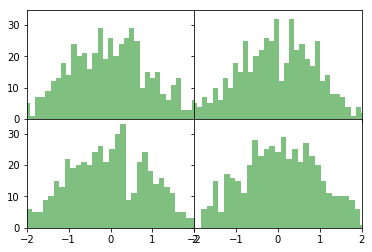

In [103]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
for i in range(2):
    for j in range(2):
        axes[i, j].hist(np.random.randn(500), bins=50, linestyle='--', color='g', alpha=0.5)
plt.subplots_adjust(wspace=0, hspace=0)
plt.xlim([-2.0,2.0])

[Text(0.5,0,'Numbers divided by 10'), Text(0.5,1,'Just another plot')]

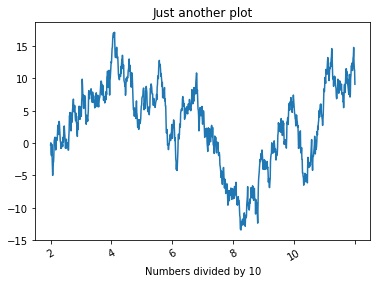

In [104]:
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
ax1.plot(np.random.randn(1000).cumsum())
ax1.set_xticklabels([0,2,4,6,8,10], rotation='30')
props = {
    'title': 'Just another plot',
    'xlabel': 'Numbers divided by 10'
}
ax1.set(**props)

In [105]:
df_experiment['1.1_Which_country_are_you_from?'].value_counts().plot.barh()

KeyError: '1.1_Which_country_are_you_from?'

In [ ]:
df_experiment['Age'].plot.hist()

In [ ]:
df_experiment['Age'].plot.density()

In [ ]:
sns.distplot(df_experiment[['Age', '3._How_long_have_you_lived_in_your_home_country?(years)']], color=['g','k'])


In [ ]:
sns.regplot('Age', 'Calc2', data=df_experiment)